<h1 align='center'> Curso de Estadística Bayesiana<br> Taller de Computación Bayesiana<h3>Autor</h3>

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 

<h3>Fork</h3>

<h3>Referencias</h3>




<h2> Modelo Binomial</h2>

<h3> El problema</h3>

Vamos a generar una observación Binomial. Para ello primero generamos un parámetro $\mu$ a partir de una distibución Beta. Usaremos los hiperparámetros $\alpha=5$ y $\beta=2$. Capricho del profesor. Vamos

In [ ]:
# Import librerias
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# genera una semilla de los números aleatorios para hacer rpetible el ejercicio
np.random.seed(seed = 500) 

<h3> Simula el parámetro $\mu$</h3>

alpha = 5
beta = 2
mu = stats.beta(alpha,beta).rvs(1)

In [3]:
print("mu= ",mu)

mu=  [0.67330565]


Este es el parámetro de interés que intentaremos recuperar más adelante.

<h3> Simula la observación aleatoria binomial $w$</h3>
Vamos a suponer un experimento $\text{Binomial} (N,\mu)$, con $N= 100$.

In [4]:
N =100
w = stats.binom(n=N, p=mu).rvs(1)

In [5]:
print("w= ",w)

w=  [69]


<h3> Calculo de la posterior</h3>

Vamos a suponer un apriori $\beta(1.2,1.2)$. NOs olvidamos de la distribiución usada para generar $\mu$, puesto en la practica se desconoce.

Veámos un gráfico

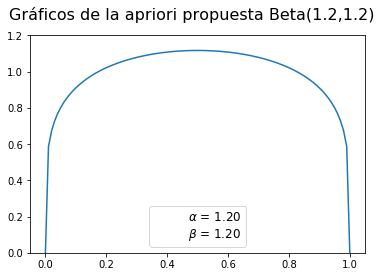

In [8]:
x = np.linspace(0,1,100)
y = stats.beta(1.2,1.2).pdf(x)

fig, ax = plt.subplots(1, 1,sharex = True, sharey = True, figsize=(6,4))
ax.set_ylim(0,1.2)
ax.plot(x,y)
ax.plot(0, 0, label="$\\alpha$ = {:3.2f}\n$\\beta$ = {:3.2f}".format(1.2, 1.2), alpha=0)
ax.legend(fontsize=12)
fig.suptitle('Gráficos de la apriori propuesta Beta(1.2,1.2)',fontsize=16)
plt.show()

Esta distribución es cercana a la uniformo $U(0,1)$. ¿Porque?

La distribución posterior es $\text{Beta}(1.2 +w, 1.2 + N-w)=\text{Beta}(70.2, 32.2)$

<h3> Estimaciones</h3>

<h4> Moda Posterior </h4>

In [10]:
from scipy.optimize import minimize_scalar as minimize

def f(t,alpha,beta):
    return  -stats.beta(alpha,beta).pdf(t)

lower = 1e-3
upper = 1  - 1e-3 
mode_f = minimize(f, bounds =(lower,upper),args=( 70.2,32.2), method='bounded' )

In [11]:
mode_f

     fun: -8.696851939248683
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.6892428669827425

In [12]:
MAP = mode_f.x

<h4> Mediana Posterior </h4>

In [13]:
MEAP = stats.beta(70.2,32.2).ppf(0.5)
MEAP
# o también
stats.beta(70.2,32.2).median()

0.6867591043997295

<h4> Media a Posterior </h4>

In [14]:
EAP = stats.beta(alpha,beta).mean()
EAP

0.7142857142857143

<h4> Intervalo de credibilidad  del 95%</h4>

In [15]:
i_cred_94 = stats.beta(70.2,32.2).ppf((0.03,0.97))
print("I.C. 94\%",i_cred_94)

I.C. 94\% [0.59676842 0.76818772]


<h4> Desviación estándar de la posterior</h4>

In [16]:
desv= stats.beta(alpha,beta).std()
desv

0.15971914124998499

<h4> Resumen Estadístico de la Distribución Posterior</h4>

|Moda |Mediana | Media |Desv.|i_3%|i_97%|
|---|---|---|---|---|---|
|0.689|0.687|0.714|0.16|0.597|0.768|

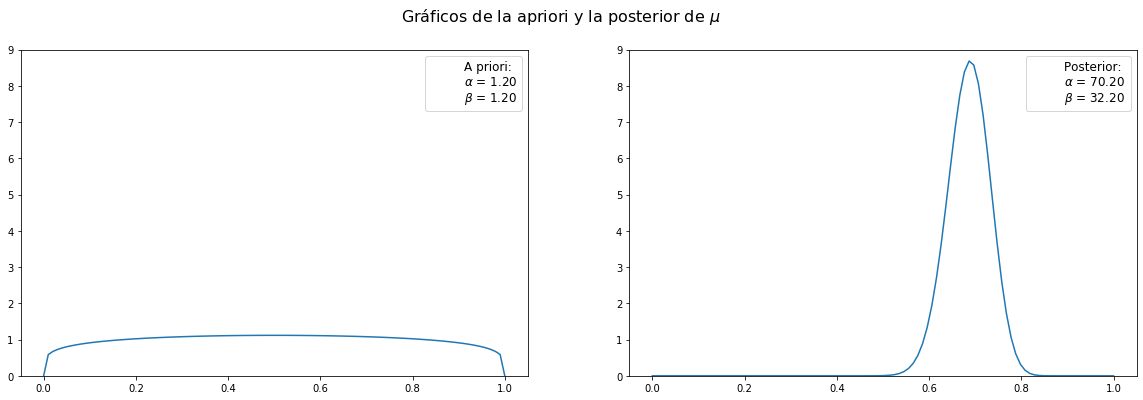

In [9]:
x = np.linspace(0,1,100)
y = stats.beta(1.2,1.2).pdf(x)

fig, ax = plt.subplots(1, 2,sharex = True, figsize=(20,6))
ax[0].set_ylim(0,9)
ax[0].plot(x,y)
ax[0].plot(0, 0, label="A priori: \n$\\alpha$ = {:3.2f}\n$\\beta$ = {:3.2f}".format(1.2, 1.2), alpha=0)
ax[0].legend(fontsize=12)

y = stats.beta(70.2,32.2).pdf(x)

ax[1].set_ylim(0,9)
ax[1].plot(x,y)
ax[1].plot(0, 0, label="Posterior: \n$\\alpha$ = {:3.2f}\n$\\beta$ = {:3.2f}".format(70.2, 32.2), alpha=0)
ax[1].legend(fontsize=12)
fig.suptitle('Gráficos de la apriori y la posterior de $\mu$',fontsize=16)
plt.show()

<h2> Stan</h2>

In [17]:
# diccionario de datos

w=69
datos_binom = {'N': N,
               'w': w,
               'a': 1.2,
               'b': 1.2}

In [18]:
datos_binom

{'N': 100, 'w': 69, 'a': 1.2, 'b': 1.2}

In [19]:
binomial_code = """
data {
    int<lower=0> N; // Tamaño del experiemnto
    int<lower=0,upper=N> w; // observacion binomial
    real<lower=0.0> a; // parámetros de la apriori: Beta(a,b)
    real<lower=0.0> b; 
}

parameters {
    real<lower=0.0001,upper=0.9999> mu;
}

model {
   mu ~ beta(a, b);
    w ~ binomial(N, mu);
}

generated quantities {
    real log_lik;
    int w_hat;
    log_lik = binomial_lpmf(w | N,mu);
    w_hat = binomial_rng(N, mu);
}
"""

In [21]:
print(binomial_code)


data {
    int<lower=0> N; // Tamaño del experiemnto
    int<lower=0,upper=N> w; // observacion binomial
    real<lower=0.0> a; // parámetros de la apriori: Beta(a,b)
    real<lower=0.0> b; 
}

parameters {
    real<lower=0.0001,upper=0.9999> mu;
}

model {
   mu ~ beta(a, b);
    w ~ binomial(N, mu);
}

generated quantities {
    real log_lik;
    int w_hat;
    log_lik = binomial_lpmf(w | N,mu);
    w_hat = binomial_rng(N, mu);
}



<h4> Compila el modelo </h4>

In [24]:
# importamos Stan
import pystan

In [25]:
# compile the  model
bm = pystan.StanModel(model_code=binomial_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_272d0aa74e332a5076a5bb5871dd7043 NOW.


<h4> Extrae las muestras de la Posterior </h4>

In [41]:
# extract the samples
samples = bm.sampling(data=datos_binom, iter=6000, chains=4,warmup=1000,thin=5)

In [42]:
samples

Inference for Stan model: anon_model_272d0aa74e332a5076a5bb5871dd7043.
4 chains, each with iter=6000; warmup=1000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu        0.68  7.2e-4   0.05   0.59   0.65   0.69   0.72   0.77   4037    1.0
log_lik  -2.94    0.01   0.69  -4.87  -3.11  -2.68   -2.5  -2.45   4017    1.0
w_hat     68.6     0.1   6.46   55.0   64.0   69.0   73.0   81.0   3938    1.0
lp__    -64.26    0.01   0.71  -66.2 -64.42 -63.99 -63.81 -63.76   4002    1.0

Samples were drawn using NUTS at Fri Apr  3 12:41:58 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

<h4> Moda de la Posterior </h4>

In [28]:
op = bm.optimizing(data=datos_binom)
op

OrderedDict([('mu', array(0.68924213)),
             ('log_lik', array(-2.45359691)),
             ('w_hat', array(77.))])

<h4> Análisis Exploratorio Bayesiano </h4>

Usaremos ArviZ

In [37]:
import arviz as az
import numpy as np
import pandas as pd
import xarray


In [43]:
az.style.use('arviz-darkgrid')

xarray.set_options(display_style="html");

stan_data = az.from_pystan(
    posterior=samples,
    posterior_predictive='w_hat',
    observed_data=['w'],
    log_likelihood={'w': 'log_lik'},
    )

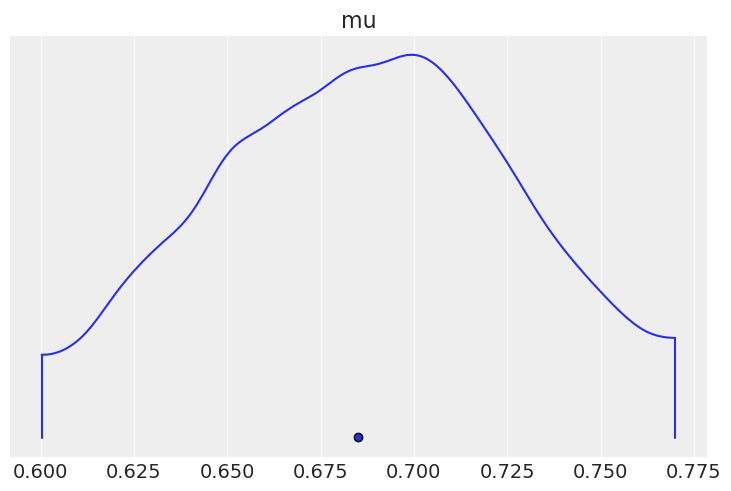

In [44]:
az.plot_density(stan_data, var_names=['mu']);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb523c3f0d0>,
      dtype=object)

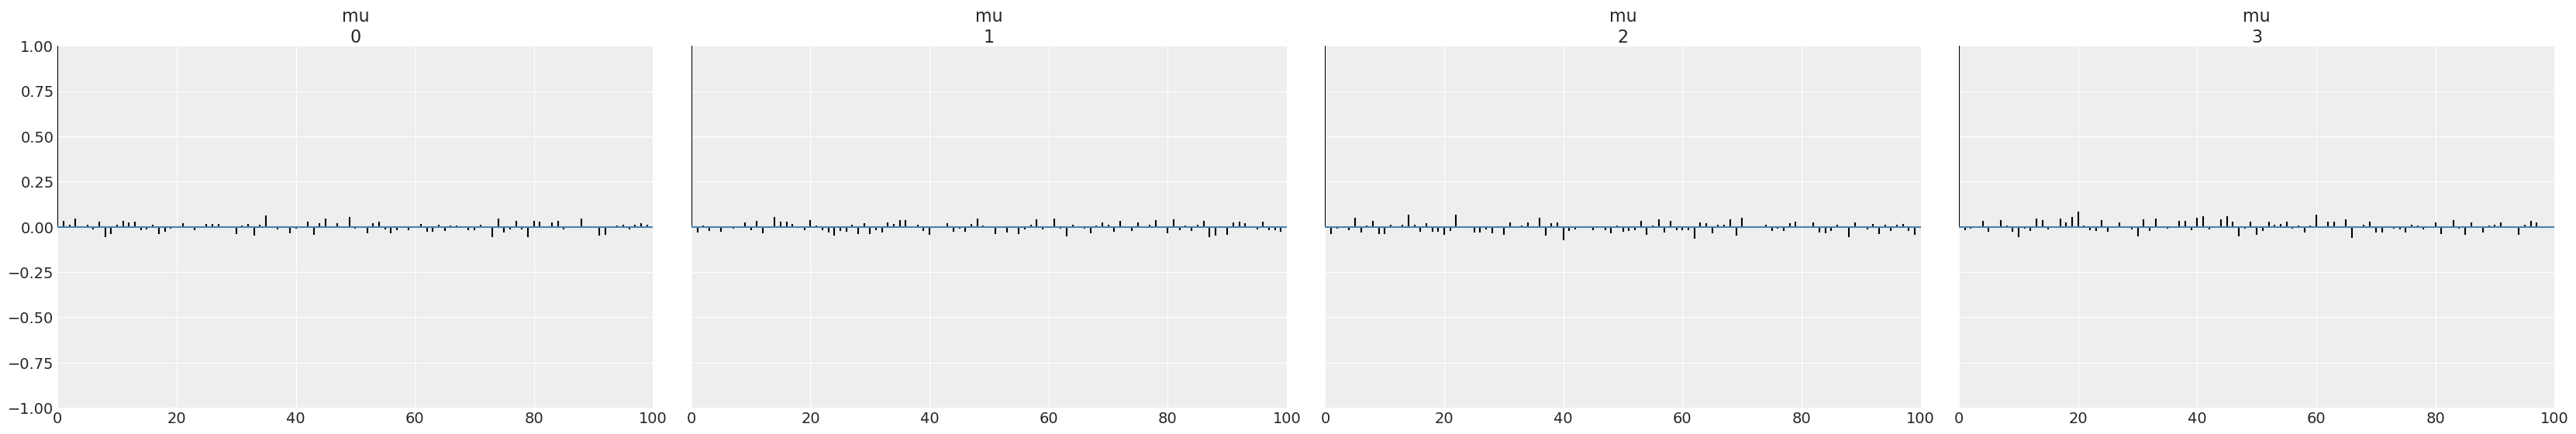

In [45]:
az.plot_autocorr(stan_data, var_names=("mu"))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb523a90610>],
      dtype=object)

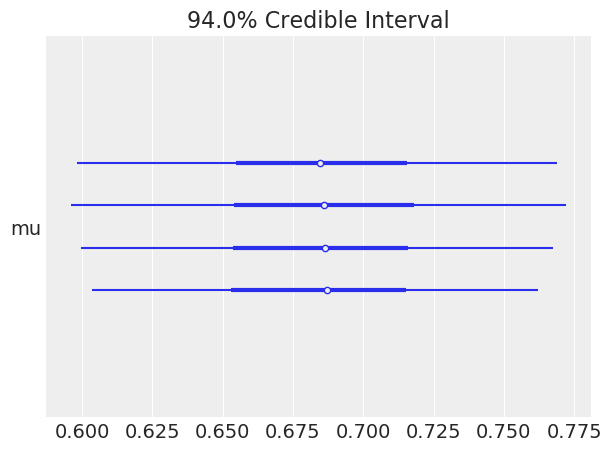

In [46]:
az.plot_forest(stan_data, var_names=("mu"))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb523a02990>,
      dtype=object)

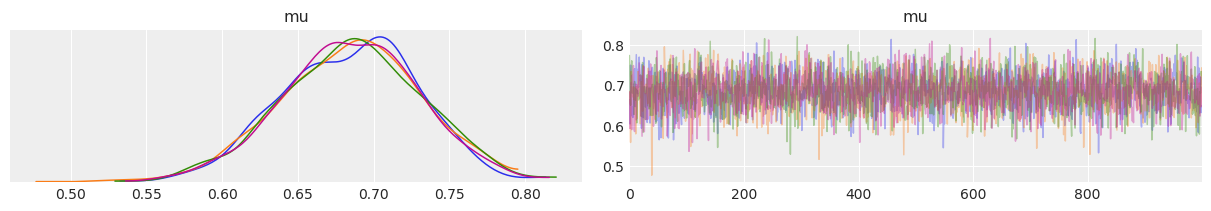

In [47]:
az.plot_trace(stan_data, var_names=("mu"))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb523e4bcd0>],
      dtype=object)

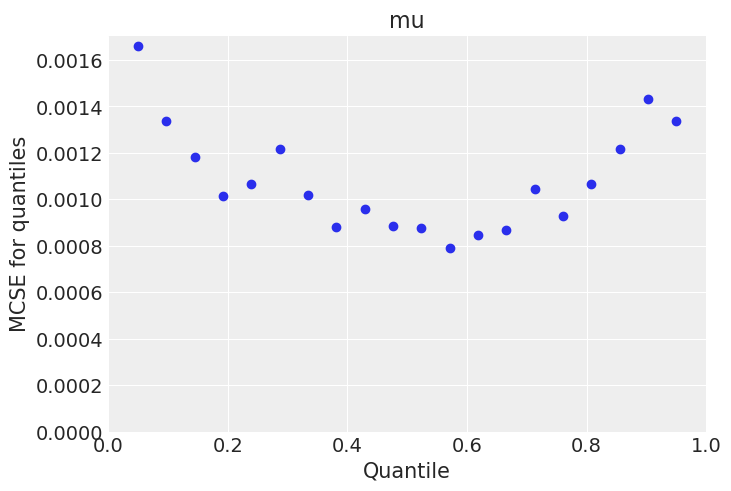

In [50]:
az.plot_mcse(stan_data)

In [48]:
az.summary(samples)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.685,0.046,0.600,0.770,0.001,0.001,4097.0,4097.0,4107.0,3971.0,1.0
log_lik,-2.943,0.695,-4.171,-2.453,0.011,0.008,4024.0,4024.0,3911.0,3808.0,1.0
w_hat,68.600,6.460,57.000,80.000,0.102,0.072,3988.0,3988.0,4013.0,4020.0,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5238c7e90>,
      dtype=object)

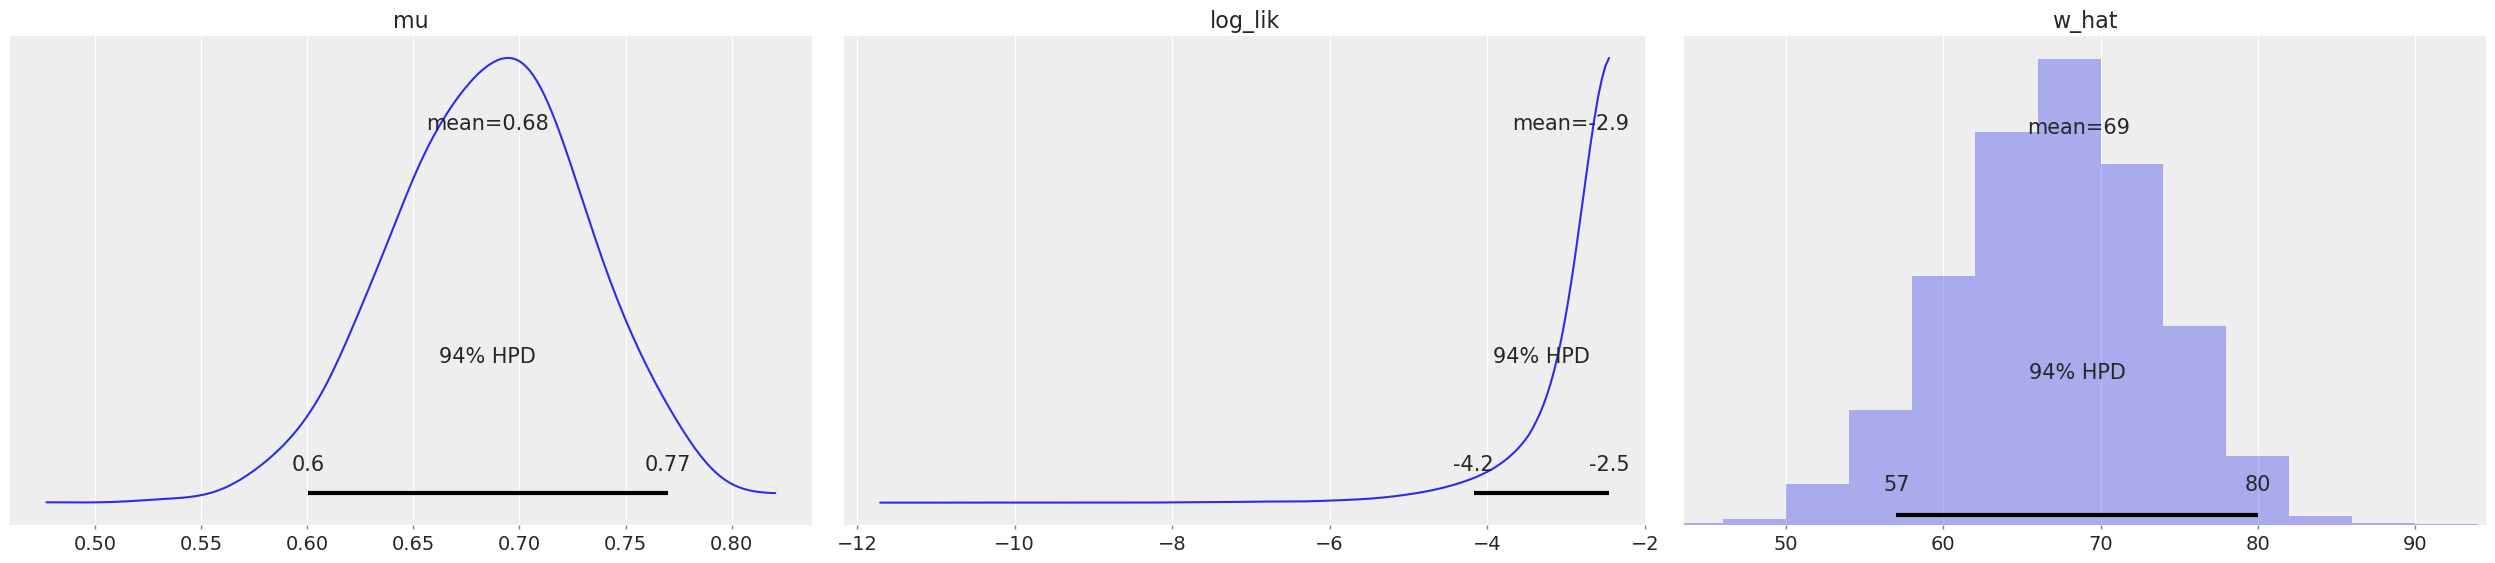

In [49]:
az.plot_posterior(samples)